GMREDI Non Hydrostatic run01 
===================================================

360x360x90x3Tr_LinProfiles_BarkleyNonHyd_GMREDI/run01
--------------------------------------------------------------

The purpose of this run is to see if the simulation going NaN's has to do with the fact that it was hydrostatic. So I used the same configuration as in run02 non hydrostatic

This ipython notebook investigates the model sensitivity to different values of vertical prescribed diffusivity coefficients using the GMREDI package. Experiment 360x360x90x3Tr_LinProfiles_BarkleyNonHyd_GMREDI/run01 has upwelling body forcing and a linear vertical gradient in the initial tracer concentration (Ran in coho). Run02 explores values of vertical diffusivity (1E-5, 1E-3,1) keeping horizontal diffusivity fixed (0.0). I traied to use only the REDI part of the package by allowing extra diagonals (#define GM_EXTRA_DIAGONAL in GMREDI_OPTIONS.h) and setting GM_background_K = 0 (no GM),GM_isopycK  = Isopycnal diffusivity (Redi part only). The simulation is 5 days long.

(Ran on Salish, 8 proc)

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl



In [2]:
#'''
#NAME
#    Custom Colormaps for Matplotlib
#PURPOSE
#    This program shows how to implement make_cmap which is a function that
#    generates a colorbar.  If you want to look at different color schemes,
#    check out https://kuler.adobe.com/create.
#PROGRAMMER(S)
#    Chris Slocum
#REVISION HISTORY
#    20130411 -- Initial version created
#    20140313 -- Small changes made and code posted online
#    20140320 -- Added the ability to set the position of each color
#'''

def make_cmap(colors, position=None, bit=False):
    #'''
    #make_cmap takes a list of tuples which contain RGB values. The RGB
    #values may either be in 8-bit [0 to 255] (in which bit must be set to
    #rue when called) or arithmetic [0 to 1] (default). make_cmap returns
    #a cmap with equally spaced colors.
    #Arrange your tuples so that the first color is the lowest value for the
    #colorbar and the last is the highest.
    #position contains values from 0 to 1 to dictate the location of each color.
    #'''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

In [3]:
def unstagger(ugrid, vgrid):
    """Interpolate u and v component values to values at grid cell centres.

    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.

    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`

    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u[..., 1:, :], v[..., 1:]


In [4]:
# Get field from MITgcm netCDF output
#
''' :statefile : string with /path/to/state.0000000000.t001.nc
    :fieldname : string with the variable name as written on the netCDF file ('Temp', 'S','Eta', etc.)'''

def getField(statefile, fieldname):
    
    StateOut = Dataset(statefile)
    
    Fld = StateOut.variables[fieldname][:]
    
    shFld = np.shape(Fld)
    
        
    if len(shFld) == 2:
        
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1])) # reshape to pcolor order
        return Fld2 
    
    elif len(shFld) == 3:
        
        Fld2 = np.zeros((shFld[0],shFld[1],shFld[2])) 
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1],shFld[2])) # reshape to pcolor order
        return Fld2
        
    elif len(shFld) == 4:
        
        Fld2 = np.zeros((shFld[0],shFld[1],shFld[2],shFld[3])) 
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1],shFld[2],shFld[3])) # reshape to pcolor order
        return Fld2
        
    else:
        
        print (' Check size of field ')
    
    



Inquire variable from NetCDF -  RUN01

In [8]:
filename='/data/kramosmu/MITgcm_c65g/SubmarineCanyons/360x360x90x3Tr__LinProfiles_BarkleyNonHyd_GMREDI/run01/mnc_0001/state.0000000000.glob.nc'
StateOut = Dataset(filename)

#for dimobj in StateOut.variables.values():
#   print dimobj


filename2='/data/kramosmu/MITgcm_c65g/SubmarineCanyons/360x360x90x3Tr__LinProfiles_BarkleyNonHyd_GMREDI/run01/mnc_0001/grid.glob.nc'
GridOut = Dataset(filename2)

#for dimobj in GridOut.variables.values():
#    print dimobj


filename3='/data/kramosmu/MITgcm_c65g/SubmarineCanyons/360x360x90x3Tr__LinProfiles_BarkleyNonHyd_GMREDI/run01/mnc_0001/ptracers.0000000000.glob.nc'
PtracersOut = Dataset(filename3)

#for dimobj in PtracersOut.variables.values():
#    print dimobj


In [9]:
# General input

nx = 360
ny = 360
nz = 90

nt = 6 # t dimension size 

z = StateOut.variables['Z']
print(z[10])
Time = StateOut.variables['T']
#print(Time[:])

xc = getField(filename2, 'XC') # x coords tracer cells

yc = getField(filename2, 'YC') # y coords tracer cells


-52.5


Geometric parameters:

* Canyon length 16180.0 m
* Canyon width at shelf break 13005.0 m
* Canyon width at half-length 7660.0 m
* Radius of curvature upstream side 5370.0 m
* Shelf break depth 150 m

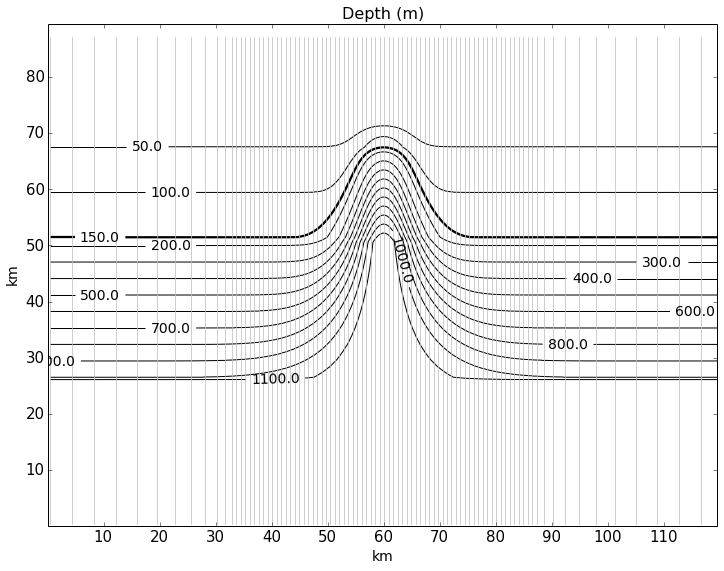

In [10]:
bathy = getField(filename2, 'Depth')

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12,9))

plt.plot(xc[::4,::4],yc[::4,::4],linewidth=0.75, linestyle='-', color='0.75')

lev = range(200,1200,100)

levels = [50,100,150]+lev

CS = plt.contour(xc,yc,bathy,levels,colors='k',linewidths=[1,1,2.25,1,1,1,1,1,1,1,1,1,1] )

plt.clabel(CS, 
           inline=1,
          fmt='%1.1f',
           fontsize=14)



plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('Depth (m)',fontsize=16)


#plt.savefig('AcrossShoreLines.png', bbox_inches='tight')
#plt.savefig('AcrossShoreLines.pdf', bbox_inches='tight')




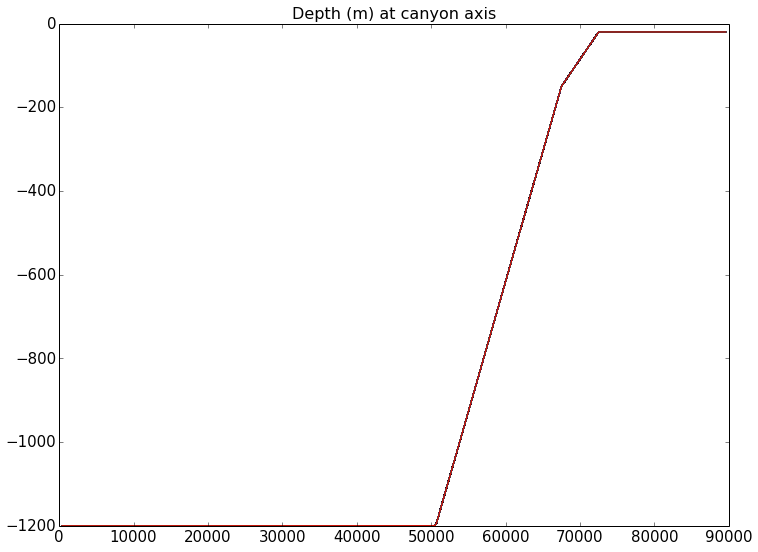

In [11]:
bathy = getField(filename2, 'Depth')

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12,9))



lev = range(200,1200,100)

levels = [50,100,150]+lev

CS = plt.plot(yc,-bathy[:,180] )


plt.title('Depth (m) at canyon axis',fontsize=16)


#plt.savefig('AcrossShoreLines.png', bbox_inches='tight')
#plt.savefig('AcrossShoreLines.pdf', bbox_inches='tight')




Jessic'a bathymetry

In [12]:
zlev = 15             # level 34 corresponds to  162.5m , near shelf break

timesc = np.arange(0,len(Time),2)   # These correspond to each day




In [13]:
ugrid = getField(filename,'U')
vgrid = getField(filename,'V')

print(np.shape(ugrid))
print(np.shape(vgrid))



(6, 90, 360, 360)
(6, 90, 360, 360)


Get mask from T field (not the best, I know)

In [14]:
temp = getField(filename, 'Temp')

temp0 = np.ma.masked_values(temp, 0)

MASK = np.ma.getmask(temp0)


# Nice cell center mask
hFacC = getField(filename2,'HFacC') #(90,360,360)

hFacCmasked = np.ma.masked_values(hFacC, 0)

MASKhFacC = np.ma.getmask(hFacCmasked)

# Nice cell open side mask
hFacW = getField(filename2,'HFacW') #(90,360,360)

hFacWmasked = np.ma.masked_values(hFacW, 0)

MASKhFacW = np.ma.getmask(hFacWmasked)

# Nice cell ? mask
hFacS = getField(filename2,'HFacS') #(90,360,360)

hFacSmasked = np.ma.masked_values(hFacS, 0)

MASKhFacS = np.ma.getmask(hFacSmasked)

In [15]:
#### T controls for plot ####

plt.rcParams.update({'font.size':13})

colorsTemp = [(245.0/255.0,245/255.0,245./255.0), (255/255.0,20/255.0,0)] #(khaki 1246/255.0,143./255.0  ,orangered2)

posTemp = [0, 1] 
 
NumLev = 30 # number of levels for contour



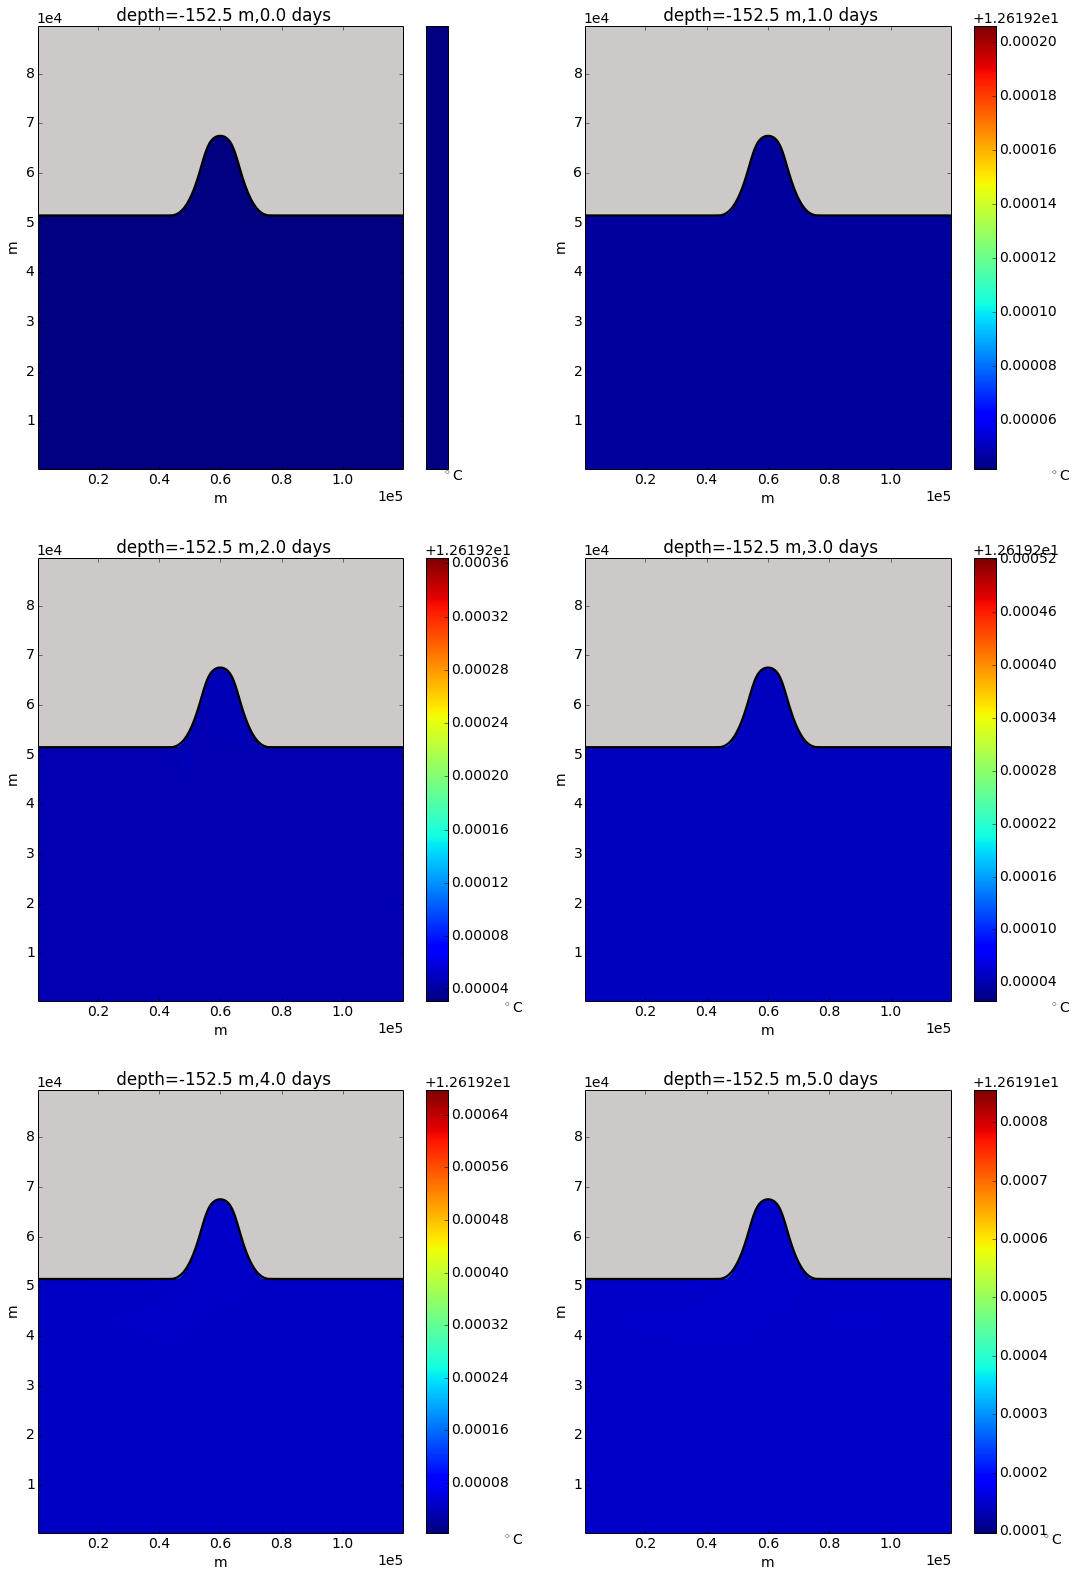

In [18]:
####  PLOT ####
zlev=30
plt.rcParams.update({'font.size':14})

kk=1

fig45=plt.figure(figsize=(18,27))

for tt in [0,1,2,3,4,5] :
        
        ### Temperature run01
        plt.subplot(3,2,kk)
        
        ax = plt.gca()
        CS = plt.contour(xc,yc,bathy,[150],colors='k',linewidths=[2.25] )
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        #plt.contourf(xc,yc,temp0[tt,zlev,:,:],NumLev)#,cmap=make_cmap(colorsTemp, position=posTemp))
        plt.pcolor(xc,yc,temp0[tt,zlev,:,:])
        #pl.clim([12,13.5])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
        plt.xlabel('m')
        plt.ylabel('m')
        
        cb = plt.colorbar()
        
        cb.set_label(r'$^{\circ}$C',position=(1, 0),rotation=0)
       
        plt.title(" depth=%1.1f m,%1.1f days " % (z[zlev],tt/1.))
        
        kk=kk+1
        

Unstagger all depths of u and v (this will be useful later when plotting cross-sections)

In [19]:
u2,v2 = unstagger(ugrid,vgrid)

#print(np.shape(u2))
#print(np.shape(v2))



Velocity plots

/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/quiver.py:570: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/quiver.py:570: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


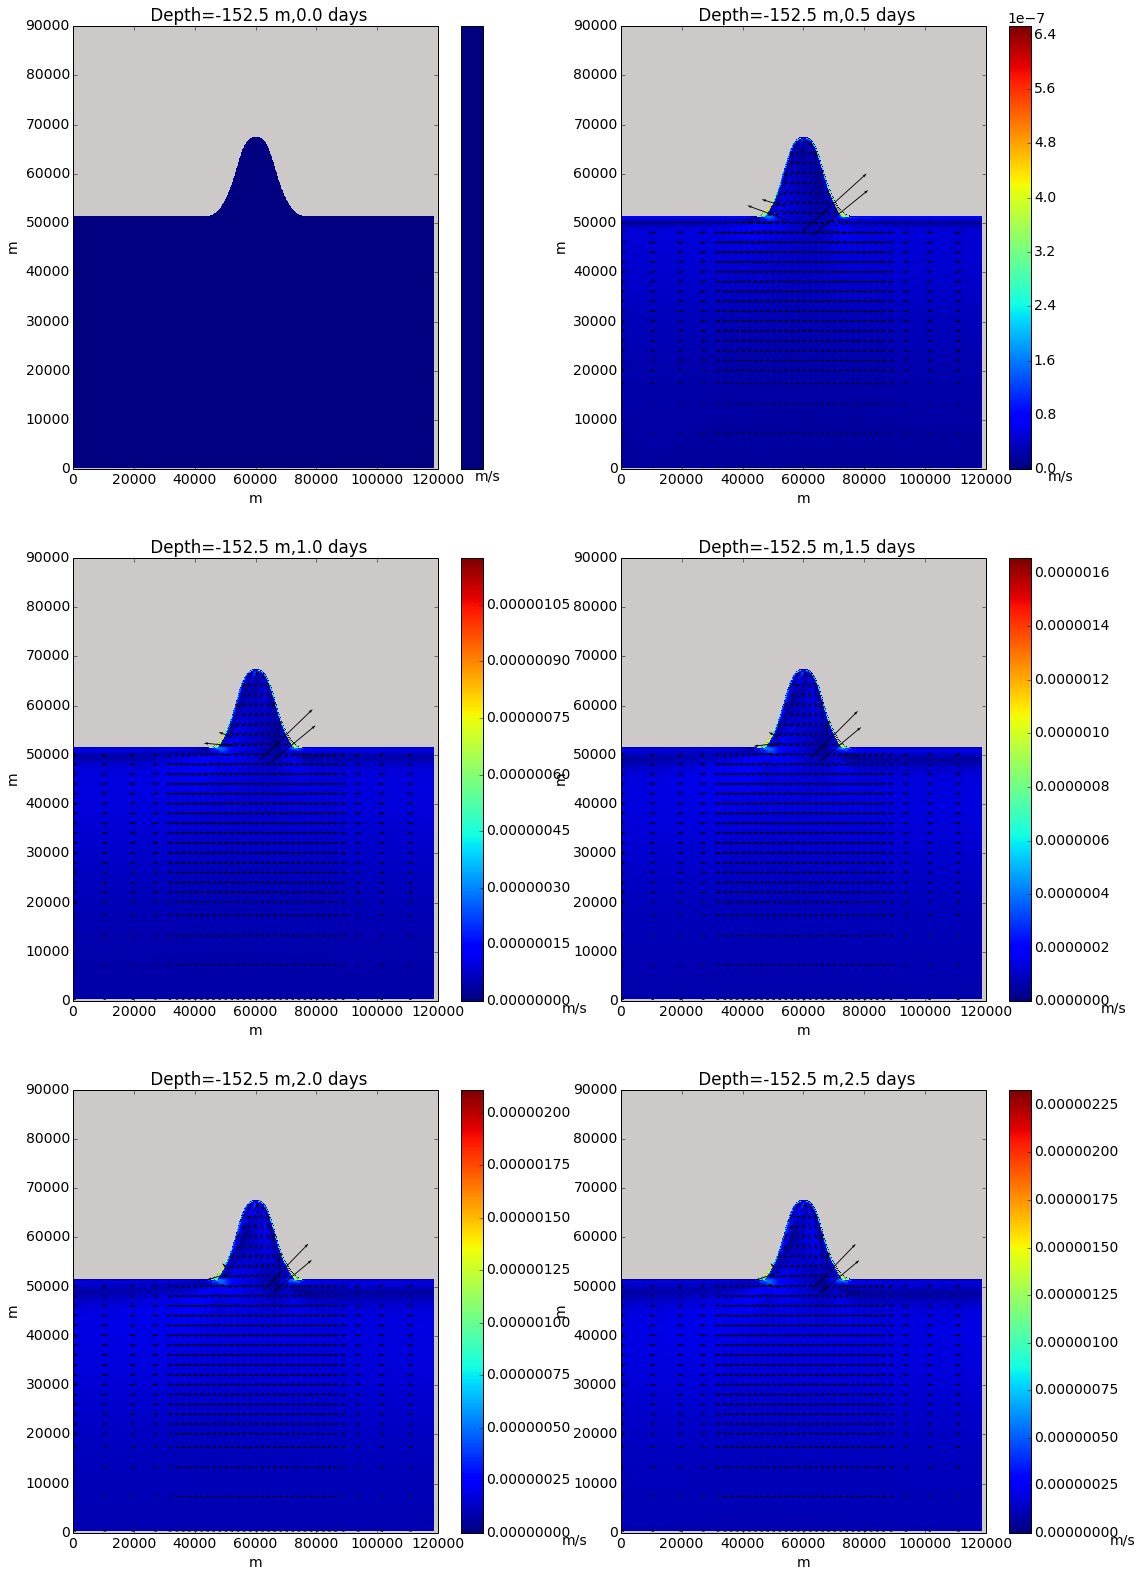

In [23]:
####  PLOT ####

plt.rcParams.update({'font.size':14})

kk=1

fig46=plt.figure(figsize=(18,27))

timesc2=[0,1,2,3,4,5]
for tt in timesc2 :
        
        ### Speed and vel vectors, run01
        
        plt.subplot(3,2,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

        umask=np.ma.array(u2[tt,zlev,:,:],mask=MASKhFacC[zlev,:-1,:-1])
        vmask=np.ma.array(v2[tt,zlev,:,:],mask=MASKhFacC[zlev,:-1,:-1])
        
        y_slice = yc[:]#np.arange(0, ny-1)
        x_slice = xc[:]#np.arange(0, nx-1)
        
        arrow_step = 10
        y_slice_a = y_slice[::arrow_step,::arrow_step]
        x_slice_a = x_slice[::arrow_step,::arrow_step]
        
        Usliceb = umask[::arrow_step,::arrow_step]
        Vsliceb = vmask[::arrow_step,::arrow_step]
        
        #print(np.shape(Uslice))
        #print(np.shape(Vslice))
        #print(np.shape(x_slice_a))
        #print(np.shape(y_slice_a))
        
        spd = np.sqrt(umask**2 + vmask**2)
        
        
        pos = [0, 1] # to keep white color on zero
        
        #colorsSpd = [(245.0/255.0,245/255.0,245./255.0), (71./255.0,60.0/255.0,139.0/255.0)] #(white-ish, Slate blue 4)
        
        #plt.contourf(xc[:-1,:-1],yc[:-1,:-1],spdb,NumLev,cmap=make_cmap(colorsSpd, position=pos))
        plt.pcolor(xc[:-1,:-1],yc[:-1,:-1],spd)
        
        cb = plt.colorbar()
        
        cb.set_label('m/s', position=(1, 0),rotation=0)
        
        plt.quiver(x_slice_a,y_slice_a,Usliceb,Vsliceb,pivot='middle' )
        
        plt.xlabel('m')
        
        plt.ylabel('m')
        
        plt.title(" Depth=%1.1f m,%1.1f days " % (z[zlev],tt/2.0))
        
        kk=kk+1



Line plots across-shelf slice at x = 39.37 km (for T)

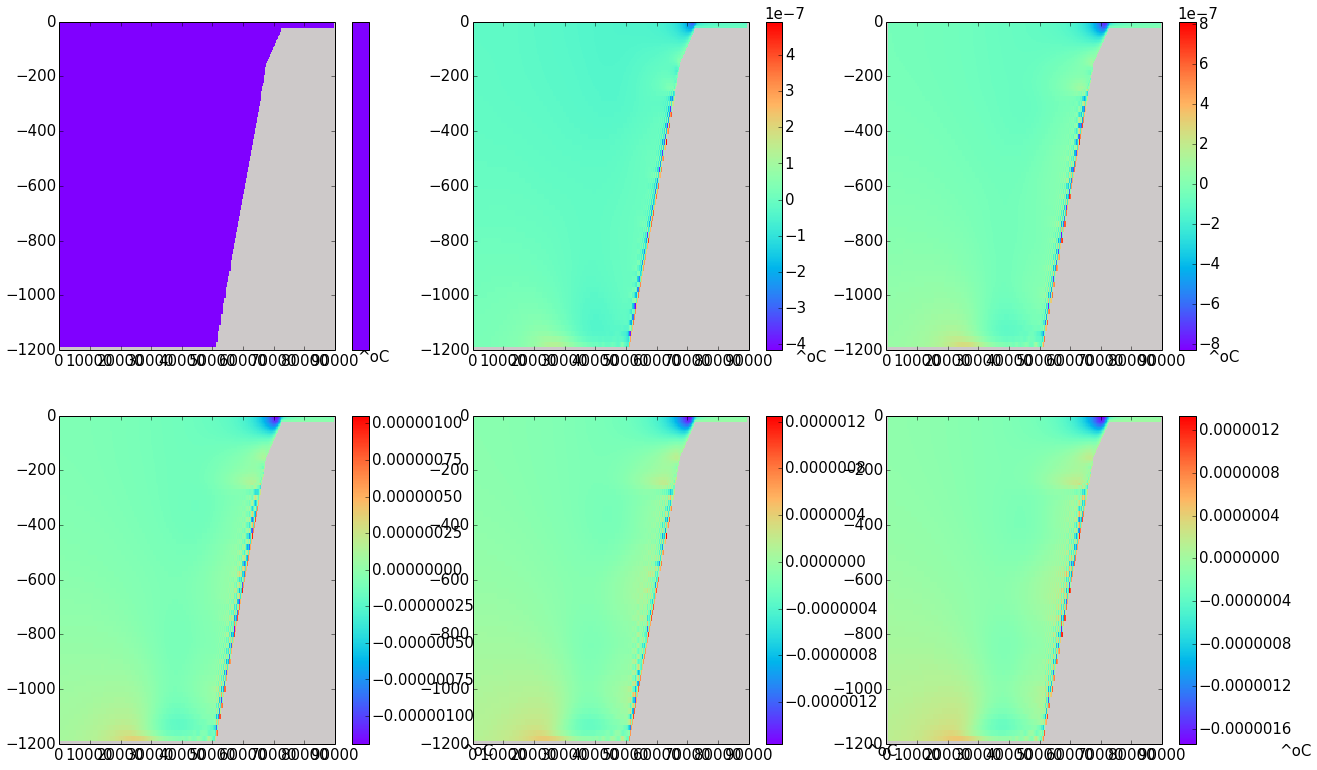

In [26]:
trac = getField(filename, 'U')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2,3,4,5] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:-1],mask=MASKhFacC[:,:,:-1])
        #Trmask=np.ma.array(u2[tt,:,:,:],mask=MASKhFacC[:,:-1,:])
        fig1=plt.pcolor(yc[:,180],z[:],Trmask[:,:,180],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       



Zoom into jet

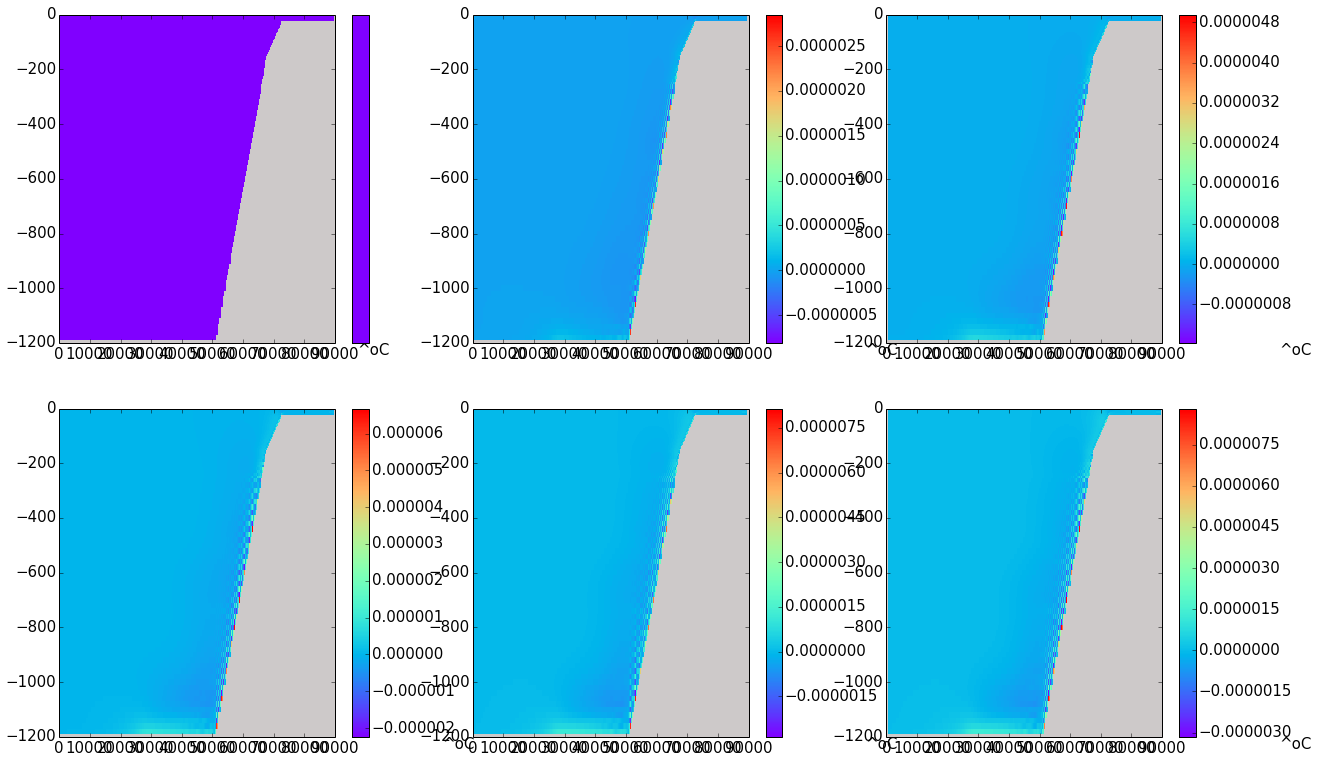

In [28]:
#trac = getField(filename, 'V')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2,3,4,5] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        #Trmask=np.ma.array(trac[tt,:,:-1,:],mask=MASKhFacC[:,:,:])
        Trmask=np.ma.array(v2[tt,:,:,:],mask=MASKhFacC[:,:-1,:-1])
       
        fig1=plt.pcolor(yc[:,180],z[:],Trmask[:,:,180],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       



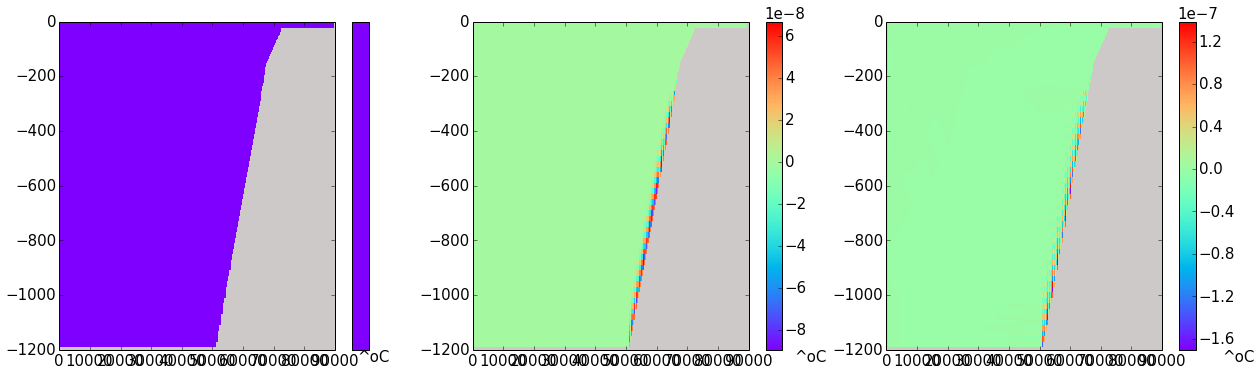

In [29]:
trac = getField(filename, 'W')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(yc[:,180],z[:],Trmask[:,:,180],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       



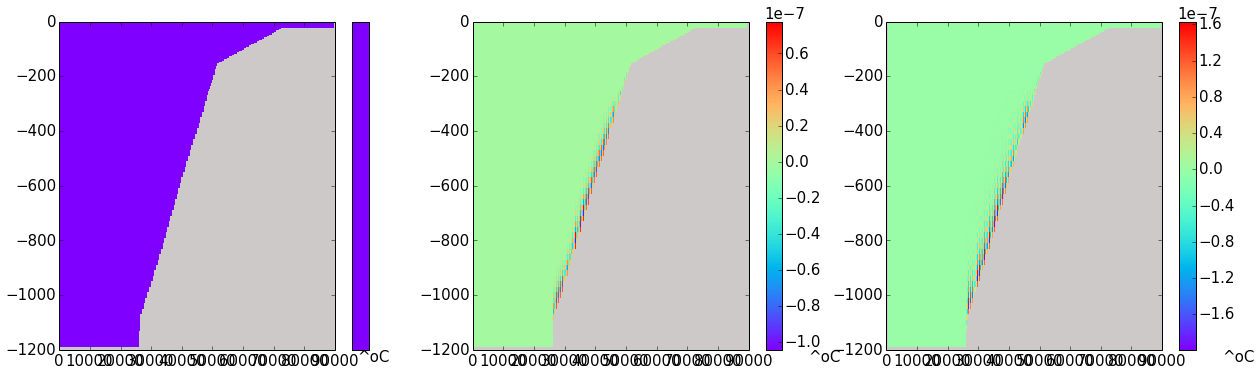

In [30]:
trac = getField(filename, 'W')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(yc[:,90],z[:],Trmask[:,:,90],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       

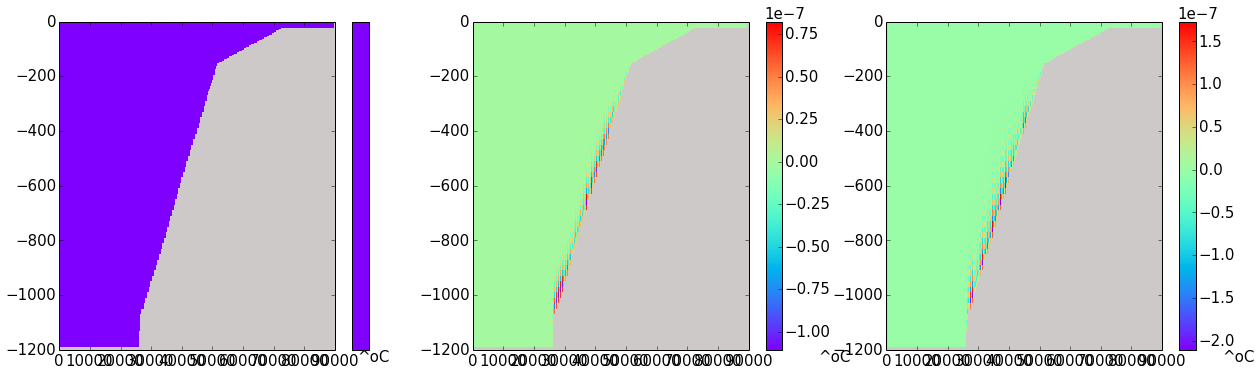

In [31]:
trac = getField(filename, 'W')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(yc[:,270],z[:],Trmask[:,:,270],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       

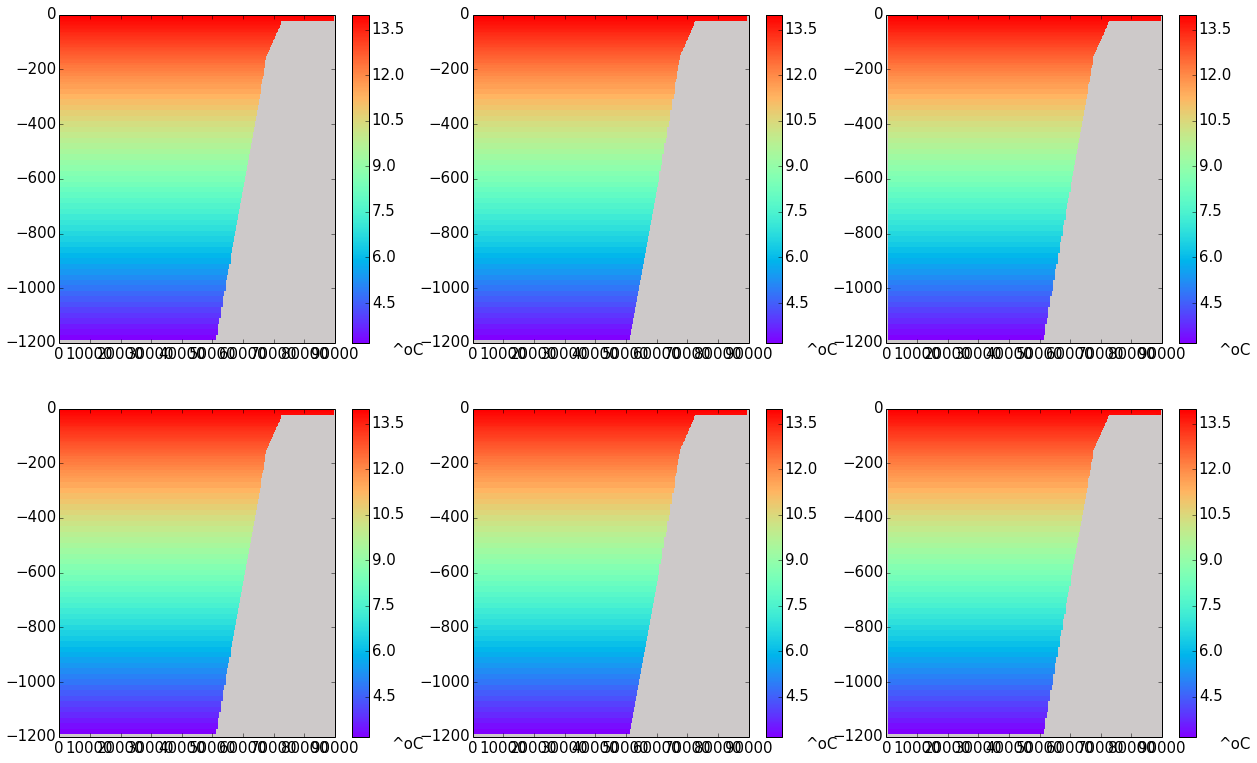

In [32]:
trac = getField(filename, 'Temp')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2,3,4,5] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(yc[:,180],z[:],Trmask[:,:,180],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       



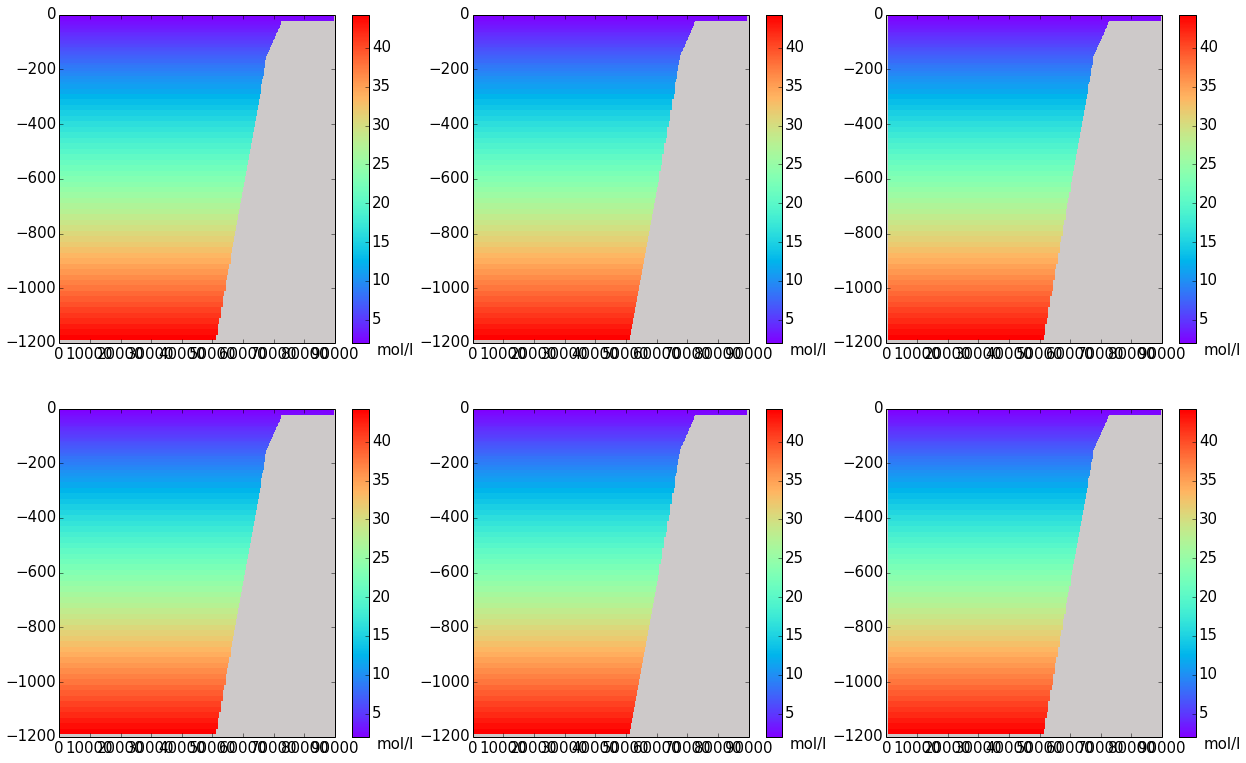

In [33]:
trac = getField(filename3, 'Tr3')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2,3,4,5] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(yc[:,180],z[:],Trmask[:,:,180],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('mol/l', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       

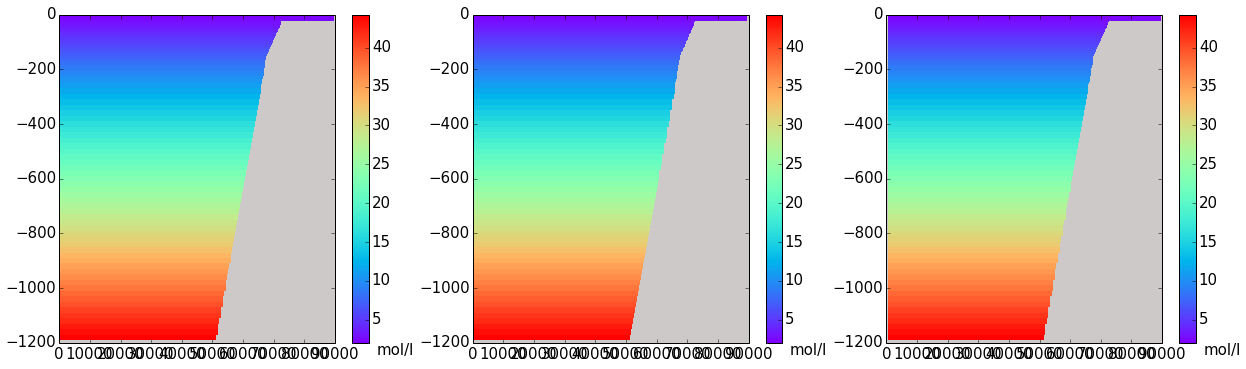

In [34]:
trac = getField(filename3, 'Tr1')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2] :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(yc[:,180],z[:],Trmask[:,:,180],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('mol/l', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        
       

In [1]:
trac = getField(filename, 'Temp')
tracB = getField(filenameB, 'Temp')

plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

for tt in [0,1,2] :
        
        ### Upstream speed 
        
        plt.subplot(3,2,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        
        Trmask=np.ma.array(trac[tt,:,:,:],mask=MASKhFacC[:,:,:])
        TrmaskB=np.ma.array(tracB[tt,:,:,:],mask=MASKhFacC[:,:,:])
       
        fig1=plt.pcolor(xc[:,:],yc[:,:],Trmask[30,:,:]-TrmaskB[30,:,:],cmap='rainbow')
        
        #pl.clim([0, 0.4])
        
        cb = plt.colorbar()
        
        cb.set_label('^oC', position=(1, 0),rotation=0)
        
        
       
            
        kk=kk+1
        

NameError: name 'getField' is not defined